In [1]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torchmetrics.image.inception import InceptionScore #https://lightning.ai/docs/torchmetrics/stable/image/inception_score.html
from torchmetrics.image.fid import FrechetInceptionDistance # https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html


class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [2]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [5]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()
            
            global_step_counter += 1

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} completed")
            torch.save(model.state_dict(), f"model_discrete_ddpm_IS_{epoch+1}.pt")


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    


# Download and transform the test dataset
dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', download=True, train=False, transform=transform),
    batch_size=batch_size,
    shuffle=False  
)


Training:   2%|▏         | 235/11750 [00:39<1:11:41,  2.68it/s, epoch=1/50, loss=⠀    119.7517, lr=9.77E-04]

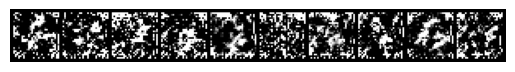

Training:   4%|▍         | 469/11750 [01:19<27:06,  6.93it/s, epoch=2/50, loss=⠀     93.9473, lr=9.54E-04]  

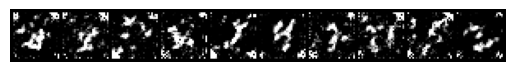

Training:   6%|▌         | 704/11750 [01:58<25:20,  7.27it/s, epoch=3/50, loss=⠀     75.3979, lr=9.32E-04]  

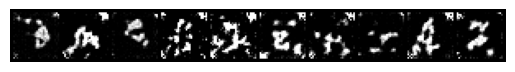

Training:   8%|▊         | 939/11750 [02:38<24:57,  7.22it/s, epoch=4/50, loss=⠀     95.8432, lr=9.10E-04]  

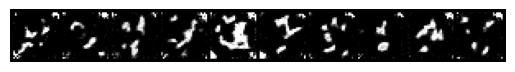

Training:  10%|▉         | 1174/11750 [03:17<24:52,  7.09it/s, epoch=5/50, loss=⠀     76.9312, lr=8.89E-04] 

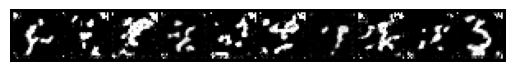

Training:  12%|█▏        | 1409/11750 [03:56<23:42,  7.27it/s, epoch=6/50, loss=⠀     62.1354, lr=8.68E-04]  

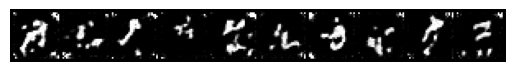

Training:  14%|█▍        | 1644/11750 [04:35<28:19,  5.95it/s, epoch=7/50, loss=⠀     92.0894, lr=8.48E-04]  

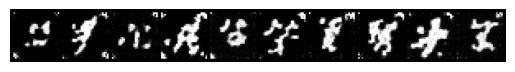

Training:  16%|█▌        | 1879/11750 [05:16<22:38,  7.27it/s, epoch=8/50, loss=⠀     86.7931, lr=8.29E-04]  

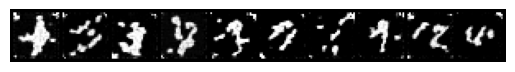

Training:  18%|█▊        | 2114/11750 [05:57<22:51,  7.02it/s, epoch=9/50, loss=⠀     94.7078, lr=8.09E-04]  

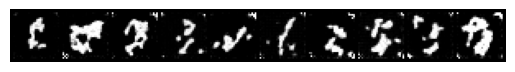

Training:  20%|█▉        | 2349/11750 [06:36<22:00,  7.12it/s, epoch=10/50, loss=⠀     74.9355, lr=7.91E-04]  

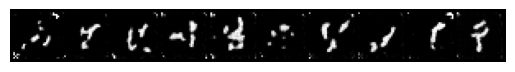

Epoch 10/50 completed


Training:  22%|██▏       | 2584/11750 [07:18<21:22,  7.15it/s, epoch=11/50, loss=⠀     69.1151, lr=7.72E-04]  

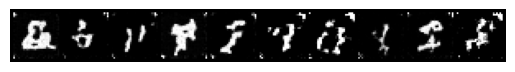

Training:  24%|██▍       | 2819/11750 [07:59<21:52,  6.80it/s, epoch=12/50, loss=⠀     80.4490, lr=7.54E-04]  

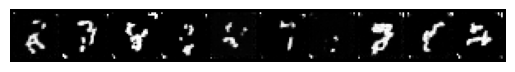

Training:  26%|██▌       | 3054/11750 [08:39<22:06,  6.56it/s, epoch=13/50, loss=⠀     97.5921, lr=7.37E-04]  

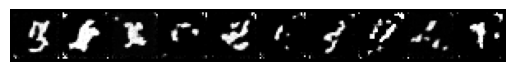

Training:  28%|██▊       | 3289/11750 [09:19<19:23,  7.27it/s, epoch=14/50, loss=⠀     87.8061, lr=7.20E-04]  

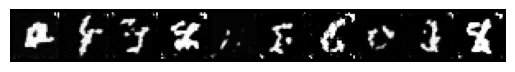

Training:  30%|██▉       | 3524/11750 [09:58<20:34,  6.66it/s, epoch=15/50, loss=⠀     90.1713, lr=7.03E-04]  

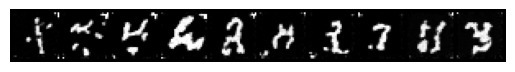

Training:  32%|███▏      | 3759/11750 [10:37<18:36,  7.16it/s, epoch=16/50, loss=⠀     84.2587, lr=6.87E-04]  

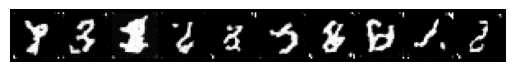

Training:  34%|███▍      | 3994/11750 [11:16<17:48,  7.26it/s, epoch=17/50, loss=⠀     83.9717, lr=6.71E-04]  

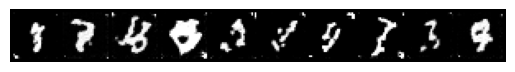

Training:  36%|███▌      | 4229/11750 [11:55<17:19,  7.24it/s, epoch=18/50, loss=⠀     94.0073, lr=6.55E-04]  

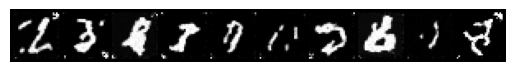

Training:  38%|███▊      | 4464/11750 [12:34<16:49,  7.22it/s, epoch=19/50, loss=⠀     87.5900, lr=6.40E-04]  

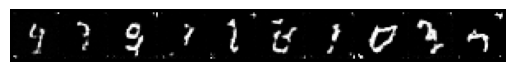

Training:  40%|███▉      | 4699/11750 [13:13<16:13,  7.24it/s, epoch=20/50, loss=⠀     91.9728, lr=6.25E-04]  

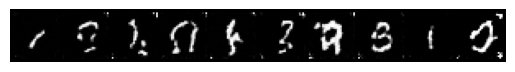

Training:  40%|████      | 4701/11750 [13:20<3:03:44,  1.56s/it, epoch=21/50, loss=⠀     84.1529, lr=6.25E-04]

Epoch 20/50 completed


Training:  42%|████▏     | 4934/11750 [13:52<15:52,  7.16it/s, epoch=21/50, loss=⠀     96.4304, lr=6.10E-04]  

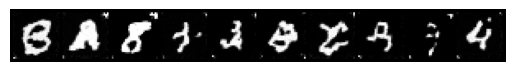

Training:  44%|████▍     | 5169/11750 [14:31<15:05,  7.26it/s, epoch=22/50, loss=⠀     82.3163, lr=5.96E-04]  

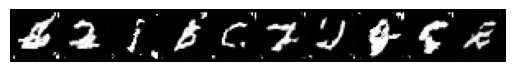

Training:  46%|████▌     | 5405/11750 [15:12<15:38,  6.76it/s, epoch=23/50, loss=⠀     84.5395, lr=5.82E-04]  

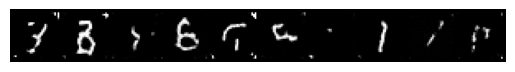

Training:  48%|████▊     | 5639/11750 [15:52<14:05,  7.23it/s, epoch=24/50, loss=⠀     95.9441, lr=5.69E-04]  

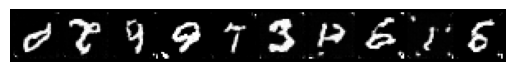

Training:  50%|████▉     | 5874/11750 [16:33<13:36,  7.20it/s, epoch=25/50, loss=⠀     86.2446, lr=5.56E-04]  

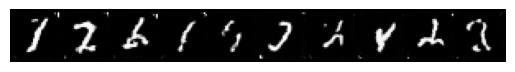

Training:  52%|█████▏    | 6109/11750 [17:13<13:55,  6.76it/s, epoch=26/50, loss=⠀     87.0227, lr=5.43E-04]  

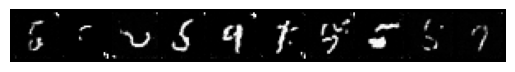

Training:  54%|█████▍    | 6345/11750 [17:53<14:18,  6.30it/s, epoch=27/50, loss=⠀     85.5231, lr=5.30E-04]  

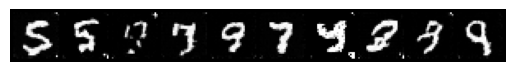

Training:  56%|█████▌    | 6579/11750 [18:33<11:56,  7.22it/s, epoch=28/50, loss=⠀     76.4176, lr=5.18E-04]  

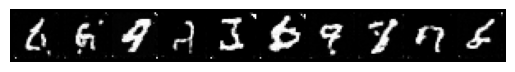

Training:  58%|█████▊    | 6814/11750 [19:13<11:28,  7.17it/s, epoch=29/50, loss=⠀     87.2378, lr=5.06E-04]  

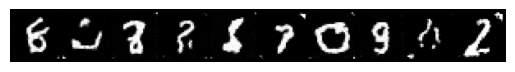

Training:  60%|█████▉    | 7049/11750 [19:52<10:45,  7.28it/s, epoch=30/50, loss=⠀     76.6545, lr=4.94E-04]  

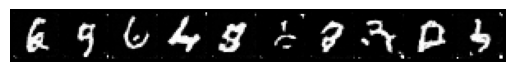

Epoch 30/50 completed


Training:  62%|██████▏   | 7284/11750 [20:31<10:17,  7.24it/s, epoch=31/50, loss=⠀     88.3077, lr=4.83E-04]  

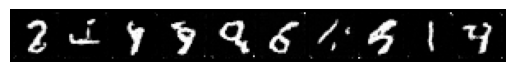

Training:  64%|██████▍   | 7519/11750 [21:10<10:05,  6.99it/s, epoch=32/50, loss=⠀     80.6325, lr=4.71E-04]  

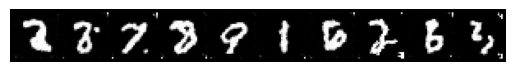

Training:  66%|██████▌   | 7754/11750 [21:50<09:10,  7.26it/s, epoch=33/50, loss=⠀     83.5785, lr=4.60E-04]  

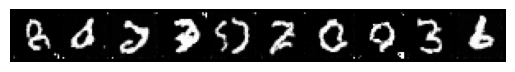

Training:  68%|██████▊   | 7989/11750 [22:29<09:00,  6.96it/s, epoch=34/50, loss=⠀     71.8871, lr=4.50E-04]  

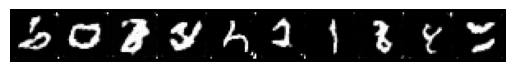

Training:  70%|██████▉   | 8224/11750 [23:09<08:38,  6.80it/s, epoch=35/50, loss=⠀     73.6703, lr=4.39E-04]  

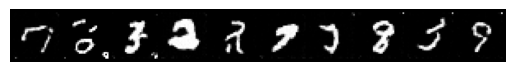

Training:  72%|███████▏  | 8459/11750 [23:49<07:33,  7.25it/s, epoch=36/50, loss=⠀     88.1796, lr=4.29E-04]  

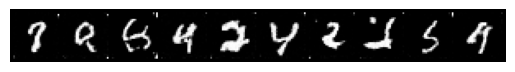

Training:  74%|███████▍  | 8694/11750 [24:31<07:20,  6.94it/s, epoch=37/50, loss=⠀     67.4488, lr=4.19E-04]  

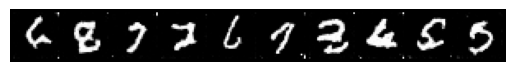

Training:  76%|███████▌  | 8929/11750 [25:12<06:54,  6.81it/s, epoch=38/50, loss=⠀     81.7357, lr=4.09E-04]  

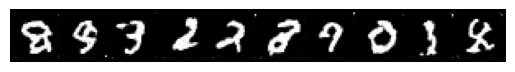

Training:  78%|███████▊  | 9164/11750 [25:54<07:12,  5.98it/s, epoch=39/50, loss=⠀     69.5671, lr=4.00E-04]  

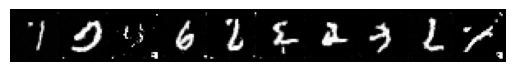

Training:  80%|███████▉  | 9399/11750 [26:36<05:59,  6.54it/s, epoch=40/50, loss=⠀     79.0014, lr=3.91E-04]  

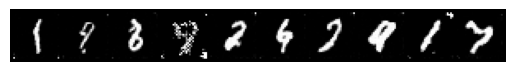

Training:  80%|████████  | 9401/11750 [26:43<1:03:39,  1.63s/it, epoch=41/50, loss=⠀     75.5377, lr=3.91E-04]

Epoch 40/50 completed


Training:  82%|████████▏ | 9634/11750 [27:15<04:54,  7.18it/s, epoch=41/50, loss=⠀     78.7521, lr=3.82E-04]  

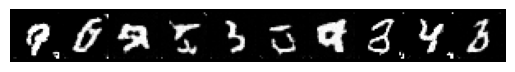

Training:  84%|████████▍ | 9869/11750 [27:55<04:20,  7.23it/s, epoch=42/50, loss=⠀     73.0486, lr=3.73E-04]

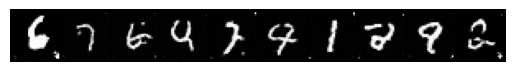

Training:  86%|████████▌ | 10104/11750 [28:35<03:47,  7.22it/s, epoch=43/50, loss=⠀     71.7299, lr=3.64E-04]

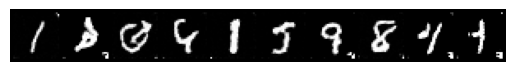

Training:  88%|████████▊ | 10339/11750 [29:16<03:18,  7.10it/s, epoch=44/50, loss=⠀     68.8541, lr=3.56E-04]

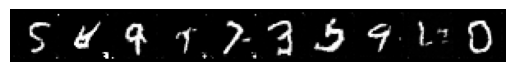

Training:  90%|████████▉ | 10574/11750 [29:56<02:43,  7.21it/s, epoch=45/50, loss=⠀     80.7961, lr=3.47E-04]

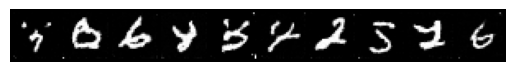

Training:  92%|█████████▏| 10809/11750 [30:38<02:16,  6.89it/s, epoch=46/50, loss=⠀     75.9334, lr=3.39E-04]

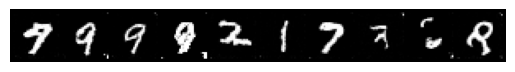

Training:  94%|█████████▍| 11044/11750 [31:20<01:38,  7.18it/s, epoch=47/50, loss=⠀     84.8516, lr=3.31E-04]

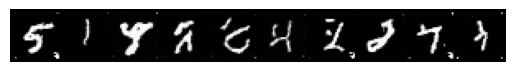

Training:  96%|█████████▌| 11279/11750 [32:01<01:04,  7.27it/s, epoch=48/50, loss=⠀     83.0163, lr=3.24E-04]

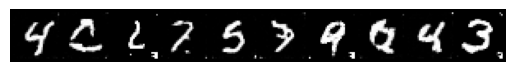

Training:  98%|█████████▊| 11514/11750 [32:41<00:35,  6.65it/s, epoch=49/50, loss=⠀     71.6894, lr=3.16E-04]

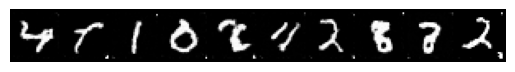

Training: 100%|█████████▉| 11749/11750 [33:22<00:00,  6.86it/s, epoch=50/50, loss=⠀     62.5263, lr=3.09E-04]

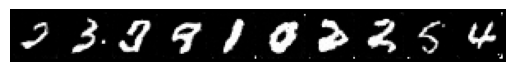

Training: 100%|██████████| 11750/11750 [33:29<00:00,  5.85it/s, epoch=50/50, loss=⠀     62.5263, lr=3.09E-04]

Epoch 50/50 completed


In [6]:

class DDPM_importance_sampler(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM_importance_sampler, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        
        # Track how many times each timestep has been sampled
        self.timestep_counter = torch.zeros(T).long().to(device)
        
        # EMA for importance sampling
        self.loss_tracker = torch.ones(T).to(device)  # Store EMA(L_t^2) for each t
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt
    
    def update_moving_avg(self, t, loss):
        """Update EMA(L_t^2) for timestep t."""
        decay = 0.99  # Decay factor for EMA
        self.loss_tracker[t] = decay * self.loss_tracker[t] + (1 - decay) * loss ** 2

    def get_p_t(self):
        """Compute p_t proportional to sqrt(EMA(L_t^2))."""
        sqrt_loss_tracker = torch.sqrt(self.loss_tracker)
        p_t = sqrt_loss_tracker / sqrt_loss_tracker.sum()  # Normalize to sum to 1
        return p_t

    def sample_t(self, batch_size):
        """Sample timesteps based on importance sampling."""
        p_t = self.get_p_t().to(self.beta.device)
        t = torch.multinomial(p_t, batch_size, replacement=True)
        return t

    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """
        
        batch_size = x0.shape[0]
        
        # sample t (in beginning of training we sample t uniformly till we draw 10 samples for every t)
        if (self.timestep_counter < 10).any():
            # uniform sampling in beginning
            t = torch.randint(0, self.T, (x0.shape[0],1)).to(x0.device)
        else:
            # importance sampling after initialization
            t = self.sample_t(batch_size).unsqueeze(1)
            
        # Update timestep counter
        for i in t:
            self.timestep_counter[i] += 1
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        # predicted noise
        epsilon_pred = self.network(xt, t)
        
        #loss = nn.MSELoss(reduction='mean')(epsilon, epsilon_pred)
        loss = nn.MSELoss(reduction='none')(epsilon, epsilon_pred).mean(dim=1)
        
        # correction by importance sampling 
        p_t = self.get_p_t()[t].to(x0.device)  # Get p_t for sampled t
        corrected_loss = (loss / p_t).mean()  # Apply reweighting

        # Update moving average for L_t^2
        for i in range(batch_size):
            self.update_moving_avg(t[i].item(), loss[i].item())
        
        return -corrected_loss

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()

# Construct model
model_importance_sampling = DDPM_importance_sampler(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model_importance_sampling.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


# Call training loop
train(model_importance_sampling, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

In [11]:
# Call training loop
#train(model, optimizer, scheduler, dataloader_train, 
#      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

from metrics import calculate_inception_score_and_fid

def evaluate(dataloader, DDPM_class, model_ckpt, device, nsamples=1000):
    """
    Evaluate model using Inception Score and FID
    
    Parameters
    ----------
    dataloader: utils.DataLoader
        Pytorch dataloader
    model: nn.Module
        Pytorch model
    model_ckpt: str
        Path to model checkpoint
    device: torch.device
        Pytorch device specification
    nsamples: int
        Number of samples to evaluate
    
    Returns
    -------
    float, float
        Inception Score, FID
    """
    
    # Load scorenet model
    scorenet = ScoreNet((lambda t: torch.ones(1).to(device)))

    #scorenet.load_state_dict(torch.load(ScoreNet_model_ckpt))


    # Load DDPM model
    model = DDPM_class(scorenet, T=T).to(device)

    # Load model checkpoint
    model.load_state_dict(torch.load(model_ckpt), strict=False)
    
    # Generate samples
    samples = model.sample((nsamples,28*28)).cpu()
    
    # Map pixel values back from [-1,1] to [0,1]
    samples = (samples+1)/2 
    samples = samples.clamp(0.0, 1.0)

    generated_samples = samples.reshape(-1, 1, 28, 28)

    real_samples = []
    for x, _ in dataloader:
        real_samples.append(x.reshape(-1, 1, 28, 28))
        if len(real_samples)*batch_size >= nsamples:
            break
    real_samples = torch.cat(real_samples, dim=0)[:nsamples].to(device)

    #add 3 channels to generated and real samples
    generated_samples = torch.cat([generated_samples, generated_samples, generated_samples], dim=1)
    real_samples = torch.cat([real_samples, real_samples, real_samples], dim=1)

    print(generated_samples.shape)
    print(real_samples.shape)

    #convert to float tensor
    generated_samples = generated_samples.float()
    real_samples = real_samples.float()

    # Calculate Inception Score and FID
    inception_mean, inception_std, FID =  calculate_inception_score_and_fid(
    generated_samples,
    real_samples,
    batch_size=32,
    device=device,
    resize=True,
    )

    return inception_mean, inception_std, FID

    



In [12]:
# Evaluate model
inception_mean, inception_std, FID = evaluate(dataloader_test, DDPM_importance_sampler, "model_discrete_ddpm_IS_50.pt", device = "cpu")


/var/folders/sk/6zwfz76x0z34qpjtwyy0r7y40000gn/T/ipykernel_69721/3732403654.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt)

torch.Size([1000, 3, 28, 28])
torch.Size([1000, 3, 28, 28])


/Users/marcusdreisler/miniconda3/envs/PML/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [13]:
inception_mean, inception_std, FID

(tensor(1.9885), tensor(0.0572), 134.97662353515625)